In [549]:
import sys
import pickle
import threading
if sys.version_info.major == 2:
    from Queue import Queue
else:
    from queue import Queue

import keras
import theano
import theano.tensor as T
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Merge, Input, Lambda, merge, Layer

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from environment import Environment
from priority_buffer import PriorityBuffer

In [1392]:
class A(Layer):
    
    # inputs are L and U and mu (in that order)
    def __init__(self, u_size, **kwargs):
        self.u_size = u_size
        self.lower_size = int(u_size * (u_size + 1) / 2.0)
        self.l_idx = list(range(self.lower_size))
        super(A, self).__init__(**kwargs)

        # Some precalculating for call()
        self.diag_idx = list(range(u_size))
        self.lower_idx1 = []
        self.lower_idx2 = []
        for i in self.diag_idx:
            for j in range(i):
                self.lower_idx1.append(i)
                self.lower_idx2.append(j)

    def build(self, input_shape):
        super(A, self).build(self.lower_size + self.u_size)
        
    def get_output_shape_for(self, input_shape):
        return (None, 1)
        
    def _p(self, x):
        l = T.zeros((x.shape[0], self.u_size, self.u_size))
        l = T.set_subtensor(l[:, self.diag_idx, self.diag_idx], T.exp(x[:, self.diag_idx]))
        if self.u_size > 1:
            l = T.set_subtensor(
                l[:, self.lower_idx1, self.lower_idx2],
                x[:, self.u_size:self.u_size + self.u_size]
            )
        return K.batch_dot(l, K.permute_dimensions(l, [0, 2, 1]))
    
    def call(self, x, mask=None):
        p = self._p(x[:, :self.lower_size])
        u = x[:, self.lower_size:self.lower_size + self.u_size]
        mu = x[:, self.lower_size + self.u_size:]
        d = K.expand_dims(u - mu, -1)
        a = -T.batched_dot(K.batch_dot(K.permute_dimensions(d, (0,2,1)), p), d)
        return a.reshape((x.shape[0], 1))
    
u_size = 2
input_size = 3 + 2 * u_size
x = Input(shape=(input_size, ), name='x')
a = A(u_size=u_size, name='A')(x)
xs = np.random.randn(10, input_size)
a.shape[1]
m = Model(input=x, output=a)
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x (InputLayer)                   (None, 7)             0                                            
____________________________________________________________________________________________________
A (A)                            (None, 1)             0           x[0][0]                          
Total params: 0
Trainable params: 0
Non-trainable params: 0
____________________________________________________________________________________________________


In [1402]:
class NAFNet2():
    
    def __init__(self, x_size, u_size, hidden_size=100):
        self.x_size = x_size
        self.u_size = u_size
        self.hidden_size = hidden_size
    
        self.x = Input(shape=(self.x_size, ), name='x')
        fc1 = Dense(input_dim=self.x_size, output_dim=self.hidden_size, activation='relu', name='fc1')(self.x)
        fc2 = Dense(input_dim=self.hidden_size, output_dim=self.hidden_size, activation='relu', name='fc2')(fc1)
        
        v = Dense(input_dim=self.hidden_size, output_dim=1, name='v')(fc2)
        self.v = Model(input=self.x, output=v)
        self.v.build(input_shape=(self.x_size, ))
        
        mu = Dense(input_dim=self.hidden_size, output_dim=2, activation='tanh', name='mu_dense')(fc2)
        self.mu = Model(input=self.x, output=mu)
        self.mu.build(input_shape=(self.x_size, ))
        
        l_all = Dense(
            input_dim=self.hidden_size,
            output_dim=int(self.u_size * (self.u_size + 1) / 2.0)
        )(fc2)
        
        self.l_all = Model(input=self.x, output=l_all)
        
        u = Input(shape=(self.u_size, ), name='u')
        a = A(u_size=self.u_size, name='A')
        
        
        self.u = Model(input=u, output=u, name='u_model')
        self.a = Sequential(
            layers=[
                Merge([self.l_all, self.u, self.mu], mode='concat', name='merge_for_p'),
                a
            ]
        )
        
        self.q = Sequential(layers=[Merge([self.a, self.v])])
        self.q.compile(loss='mse', optimizer='adam')
        
nn2 = NAFNet2(x_size=4, u_size=2)

In [1404]:
def gen():
    while True:
        x = np.random.randn(32, 4)
        u = np.random.randn(32, 2)
        y = np.random.randn(32, 1)
        yield [x, u], y
    
nn2.q.fit_generator(gen(), samples_per_epoch=128, nb_epoch=128)

INFO (theano.gof.compilelock): Refreshing lock /Volumes/user/isac/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Epoch 1/128
128/128 [==============================] - 0s - loss: 4.8995     
Epoch 2/128
128/128 [==============================] - 0s - loss: 3.3031     
Epoch 3/128
128/128 [==============================] - 0s - loss: 2.4084     
Epoch 4/128
128/128 [==============================] - 0s - loss: 1.6195     
Epoch 5/128
128/128 [==============================] - 0s - loss: 1.3411     
Epoch 6/128
128/128 [==============================] - 0s - loss: 1.2634     

In [1345]:
%debug

> /usr/local/lib/python3.6/site-packages/keras/engine/training.py(91)standardize_input_data()
     89             raise ValueError('The model expects ' + str(len(names)) +
     90                              ' input arrays, but only received one array. '
---> 91                              'Found: array with shape ' + str(data.shape))
     92         arrays = [data]
     93 

ipdb> l
     86         if len(names) != 1:
     87             # case: model expects multiple inputs but only received
     88             # a single Numpy array
     89             raise ValueError('The model expects ' + str(len(names)) +
     90                              ' input arrays, but only received one array. '
---> 91                              'Found: array with shape ' + str(data.shape))
     92         arrays = [data]
     93 
     94     # make arrays at least 2D
     95     for i in range(len(names)):
     96         array = arrays[i]

ipdb> data
array([[ 0.38690758, -1.22145663,  0.01365321,

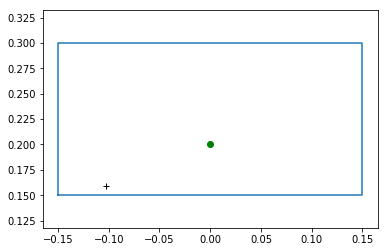

In [2]:
def random_in_range(a, b):
    if b < a:
        raise ValueError('b should not be less than a')
    return np.random.rand() * (b - a) + a

e = Environment(goal=(0.0, 0.2))
e.plot()
plt.show()

def create_state_vector(eef_x, eef_y, goal_x, goal_y):
    return np.array([
        [eef_x, eef_y, goal_x, goal_y]
    ], dtype=np.float32)

In [64]:
class NAFNet():
    
    def __init__(self, batch_size=256):
        # inputs: goal x, y, eef x, y
        self.batch_size = batch_size
        self.control_size = 2
        self.weight_std = 4.0
        self.gamma = 0.5
        self.hidden_size = 100
        self._setup()
        
    def _setup(self):
        X = T.fmatrix('X')

        # First fully connected layer
        W1 = theano.shared(
            value=np.random.randn(4, self.hidden_size) / self.weight_std,
            name='W1'
        )
        b1 = theano.shared(
            value=np.zeros(self.hidden_size),
            name='b1'
        )
        Y1 = T.nnet.nnet.relu(T.dot(X, W1) + b1)

        # Second fully connected layer
        W2 = theano.shared(
            value=np.random.randn(self.hidden_size, self.hidden_size) / self.weight_std,
            name='W2'
        )
        b2 = theano.shared(
            value=np.zeros(self.hidden_size),
            name='b2'
        )
        Y2 = T.nnet.nnet.relu(T.dot(Y1, W2) + b2)

        # To value function estimate
        WV = theano.shared(
            value=np.random.randn(self.hidden_size, 1) / self.weight_std,
            name='WV'
        )
        bv = theano.shared(np.float32(0.0))
        V = T.dot(Y2, WV) + bv

        # µ
        Wmu = theano.shared(
            value=np.random.randn(self.hidden_size, self.control_size) / self.weight_std,
            name='Wmu'
        )
        bmu = theano.shared(np.float32(0.0))
        mu = 0.15 * T.tanh(T.dot(Y2, Wmu) + bmu)

        # Construct L matrices
        WL_diag = theano.shared(
            value=np.random.randn(self.hidden_size, self.control_size) / self.weight_std,
            name='WL_diag'
        )
        bl_diag = theano.shared(
            value=np.zeros(self.control_size),
            name='bl_diag'
        )

        YL_diag = T.exp(T.dot(Y2, WL_diag) + bl_diag)

        l_lower_size = int((self.control_size - 1) * self.control_size / 2.0)
        WL_lower = theano.shared(
            value=np.random.randn(self.hidden_size, l_lower_size) / self.weight_std,
            name='WL_lower'
        )
        bl_lower = theano.shared(
            value=np.zeros(l_lower_size),
            name='bl_lower'
        )
        YL_lower = T.dot(Y2, WL_lower) + bl_lower

        diag_idx = np.arange(0, self.control_size, 1).astype(int)
        L = T.zeros((self.batch_size, self.control_size, self.control_size))
        L_diag = T.set_subtensor(L[:, diag_idx, diag_idx], YL_diag)
        lower_idx1 = []
        lower_idx2 = []
        for i in range(1, self.control_size):
            for j in range(i):
                lower_idx1.append(i)
                lower_idx2.append(j)
        L_lower = T.set_subtensor(L[:, lower_idx1, lower_idx2], YL_lower)
        L = L_diag + L_lower
        P = T.batched_dot(L, L.dimshuffle([0, 2, 1]))

        U = T.fmatrix('U')
        d = U - mu
        A_tmp = T.batched_dot(d, P)
        A = -T.batched_dot(d, A_tmp.reshape([self.batch_size, self.control_size, 1]))

        Q = A + V

        self.params = [W1, b1, W2, b2, WV, bv, Wmu, bmu, WL_diag, bl_diag, WL_lower, bl_lower]
        
        # Test fitting the q function
        q_target = T.fmatrix('q_target')
        q_loss = T.sum((q_target - Q) ** 2) / batch_size
        
        self._mu = theano.function(
            inputs=[X],
            outputs=mu,
            allow_input_downcast=True
        )
        
        self._q = theano.function(
            inputs=[X, U],
            outputs=Q,
            allow_input_downcast=True
        )
        
        gradients = T.grad(q_loss, wrt=self.params)
        rate = np.float32(1e-4)
        self._f_train_q = theano.function(
            inputs=[X, U, q_target],
            outputs=q_loss,
            updates=[(param, param - rate * grad) for param, grad in zip(self.params, gradients)],
            allow_input_downcast=True
        )
        
    def q_function(self, x, u):
        return self._q(x, u)
    
    def mu(self, x):
        return self._mu(x)[0, :]
    
    def train_q(self, x, u, q_target):
        return self._f_train_q(x, u, q_target)
        
        
batch_size = 256
nn = NAFNet(batch_size=batch_size)

In [40]:
def test_score(environment, policy, goal_x=0.0, goal_y=0.2):
    np.random.seed(0)
    n_tries = 64
    n_steps = 4
    score_total = 0.0
    for i in range(n_tries):
        environment.reset()
        environment.goal_x = goal_x
        environment.goal_y = goal_y
        score_run = 0.0
        for _ in range(n_steps):
            action = nn.mu(create_state_vector(
                environment.eef_x,
                environment.eef_y,
                environment.goal_x,
                environment.goal_y
            ))
            score_total += environment.move(*action)
    return score_total

e = Environment()
test_score(e, nn)

-172.03617055231331

In [ ]:
#with open('params.pkl', 'rb') as fh:
#    param_values = pickle.load(fh)
#[a.set_value(b) for a, b in zip(params, param_values)]
#param_values = [p.get_value() for p in params]
#with open('params.pkl', 'wb') as f:
#    pickle.dump(param_values, f, protocol=2)

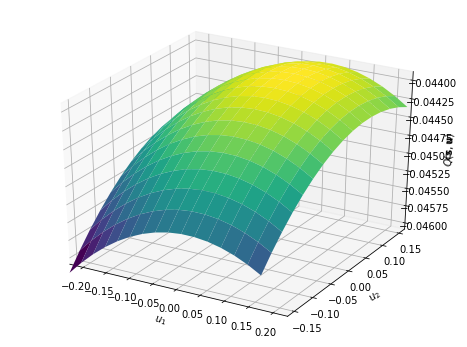

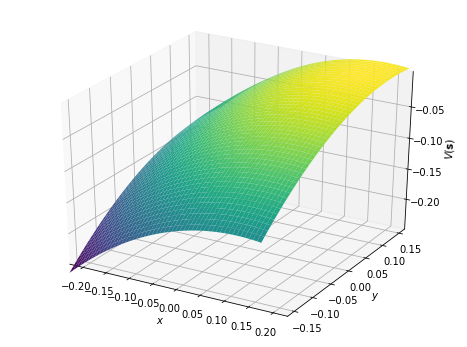

0.15 0.15


array([ 0.09077767,  0.03833021])

In [97]:
def plot_q(nn, batch_size=256):
    x = np.array([[0.0, 0.0, 0.0, 0.0] for _ in range(batch_size)], dtype=np.float32)
    control_range = np.linspace(-0.2, 0.2, 16)
    u = np.array([[a, b] for a in control_range for b in control_range], dtype=np.float32)
    q = nn.q_function(x, u)

    xs, ys = np.meshgrid(control_range, control_range)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    zs = np.zeros((16, 16))
    for i in range(16):
        for j in range(16):
            zs[i, j] = q[i * 16 + j]
    ax.plot_surface(xs, ys, zs, cmap='viridis', shade=True)
    plt.xlabel('$u_1$')
    plt.ylabel('$u_2$')
    ax.set_zlabel('$Q(\mathbf{s}, \mathbf{u})$')
    plt.axis('equal')
    #plt.savefig('naf_q_over_u_surface_random.pdf')
    plt.show()
    
plot_q(nn)

def convex_shape(x, y):
    v = np.array([[x, y]])
    mu = np.array([[0.15, 0.15]])
    return -np.dot((v - mu), (v - mu).T)

xs_1d = np.linspace(-0.2, 0.2)
ys_1d = np.linspace(-0.2, 0.2)
xs, ys = np.meshgrid(xs_1d, ys_1d)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
zs = np.zeros(xs.shape)
for i in range(xs.shape[0]):
    for j in range(xs.shape[1]):
        zs[i, j] = convex_shape(xs_1d[i], ys_1d[j])
ax.plot_surface(xs, ys, zs, cmap='viridis', shade=True)
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_zlabel('$V(\mathbf{s})$')
plt.axis('equal')
plt.show()

print(0.15, 0.15)
nn.mu(np.array([[0.0, 0.0, 0.0, 0.0]]))

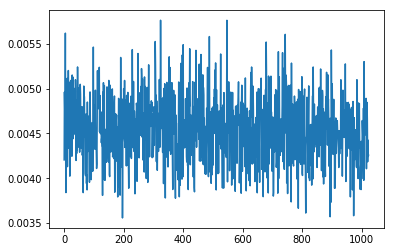

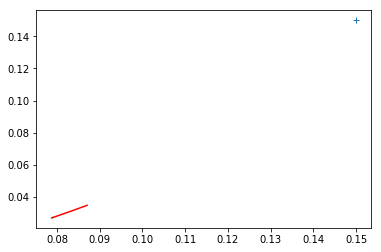

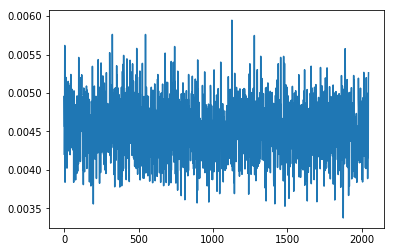

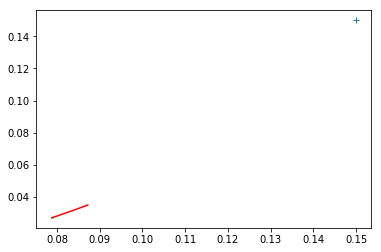

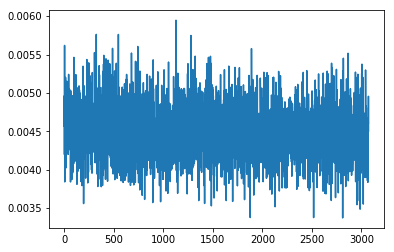

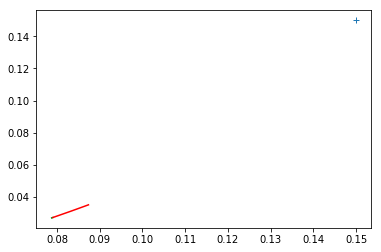

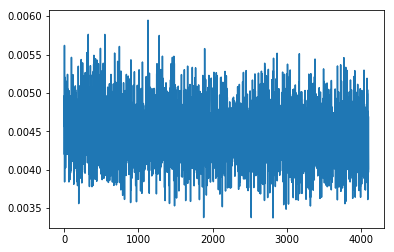

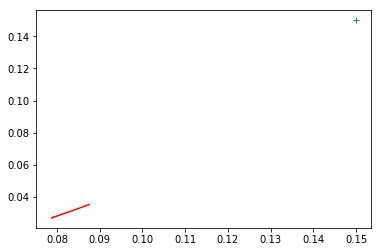

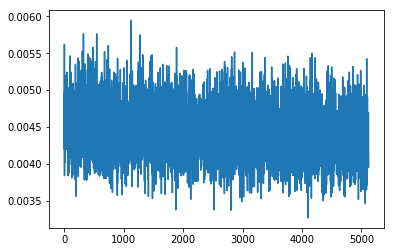

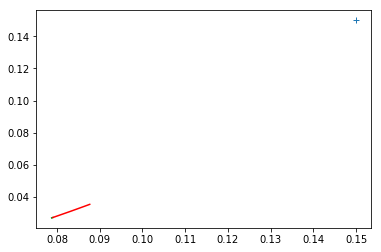

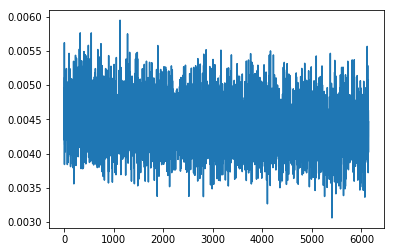

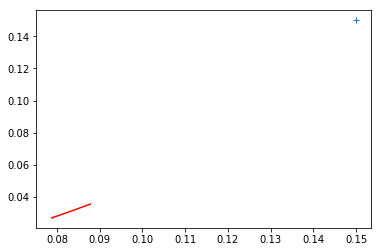

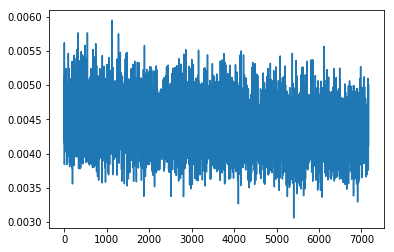

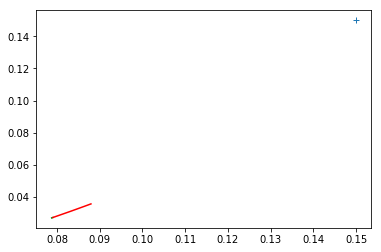

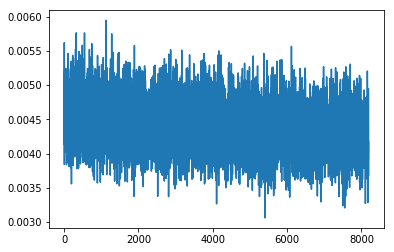

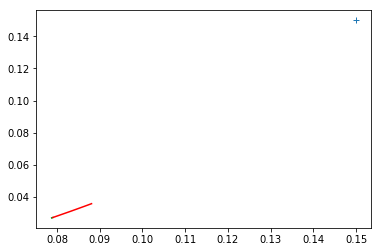

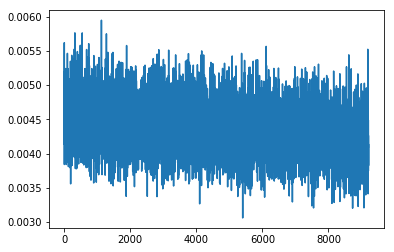

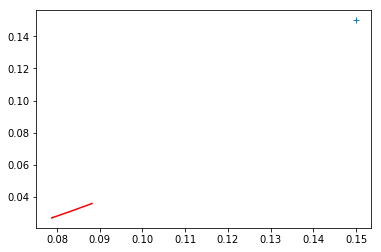

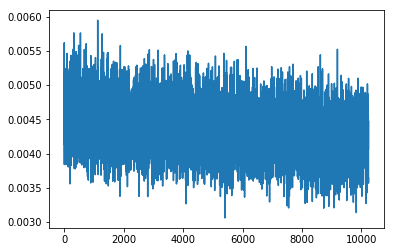

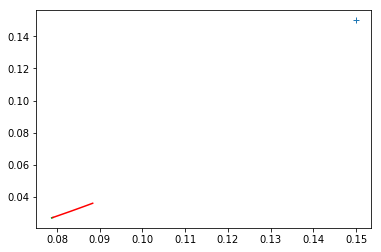

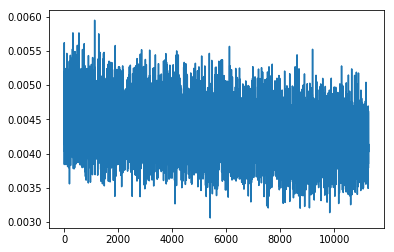

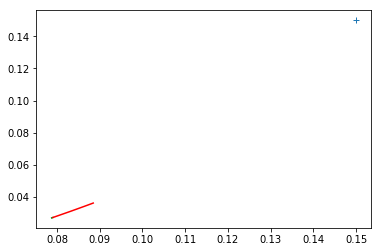

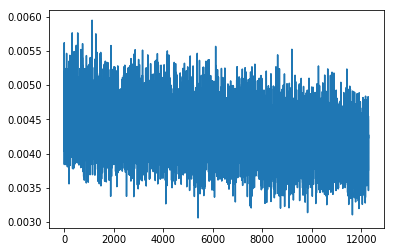

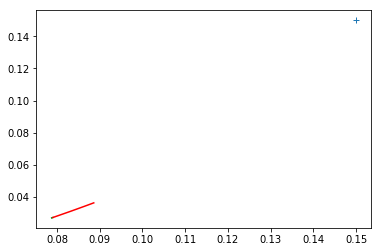

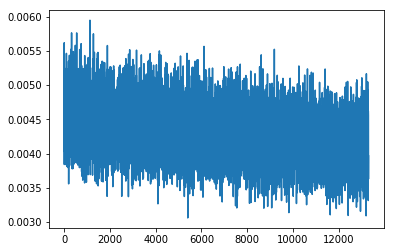

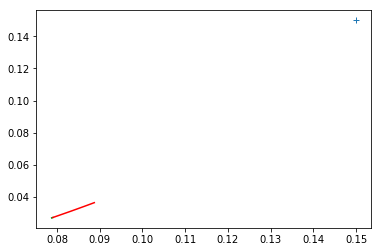

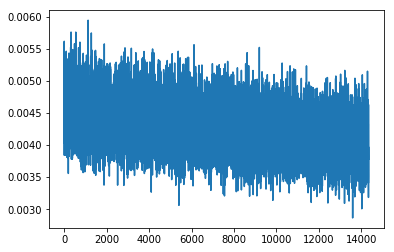

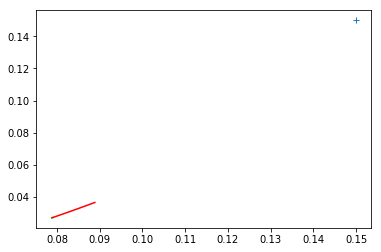

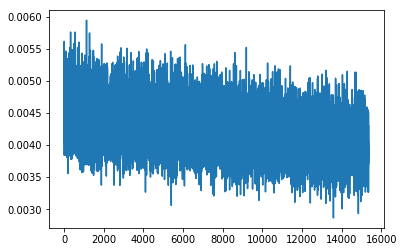

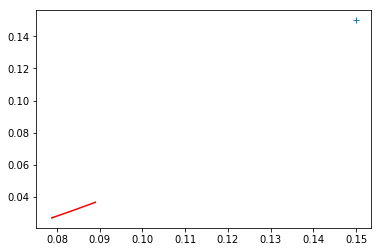

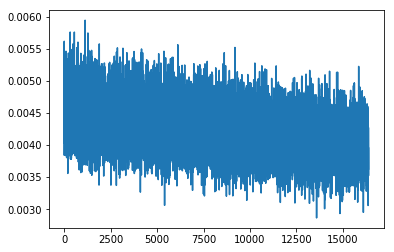

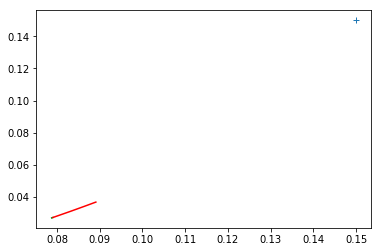

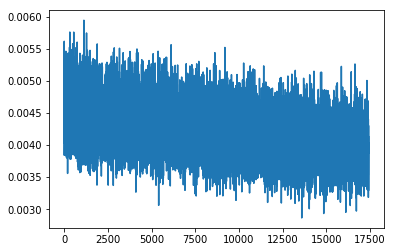

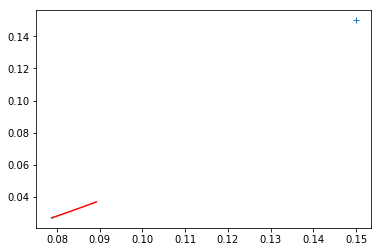

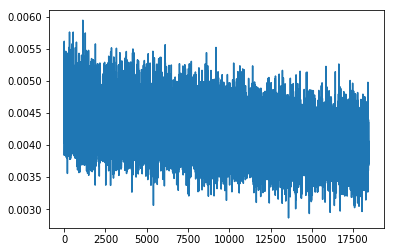

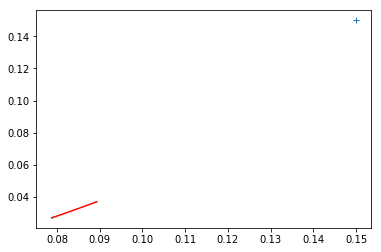

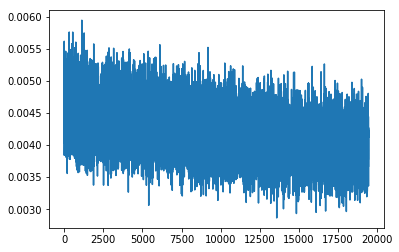

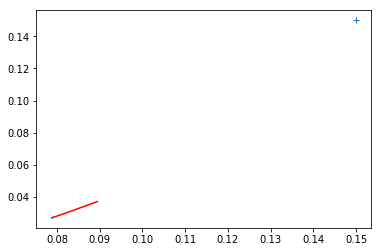

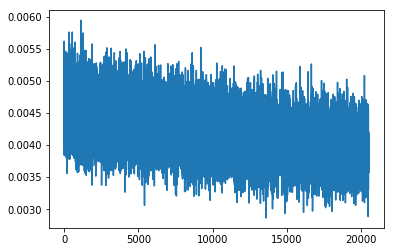

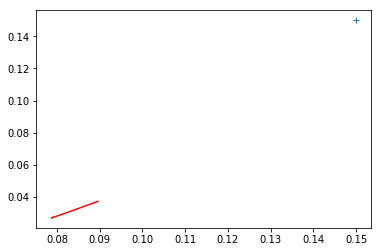

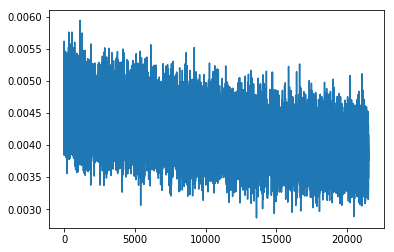

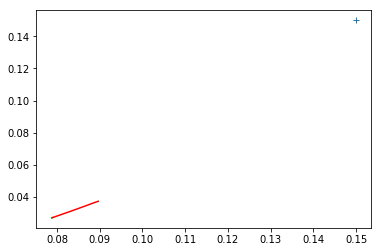

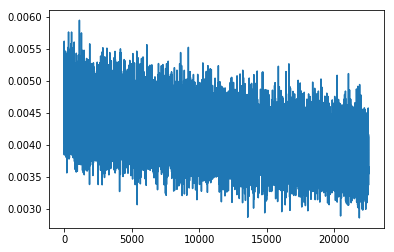

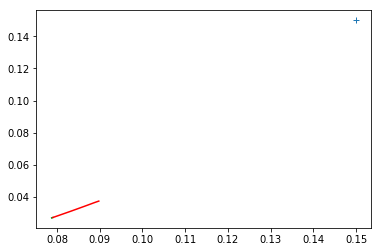

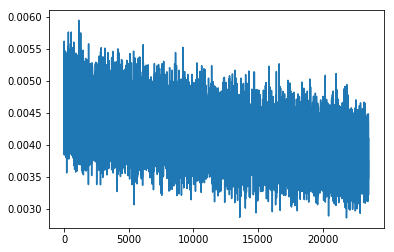

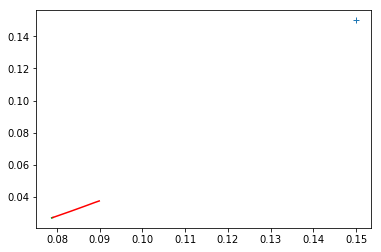

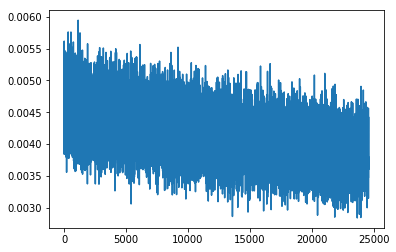

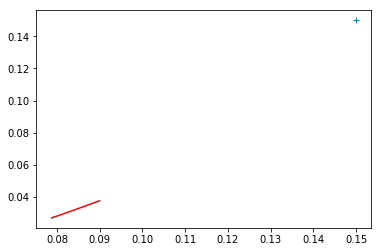

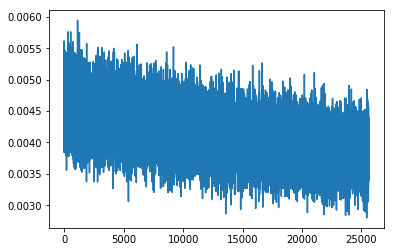

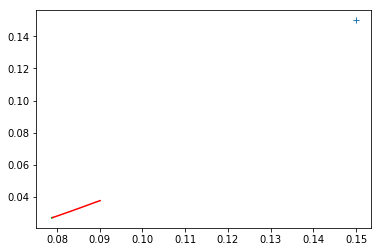

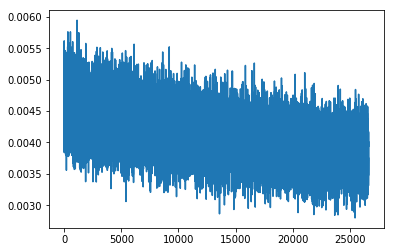

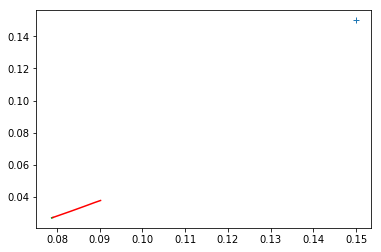

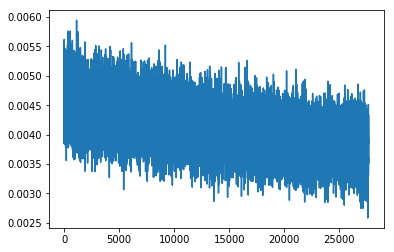

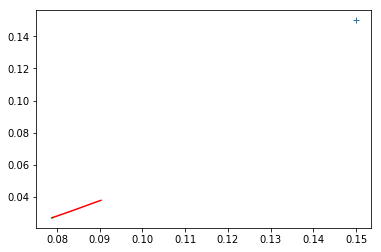

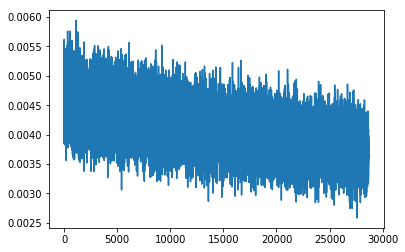

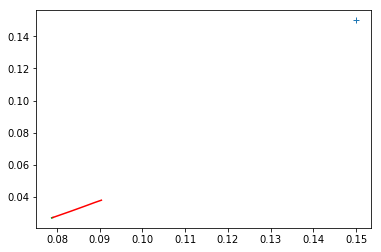

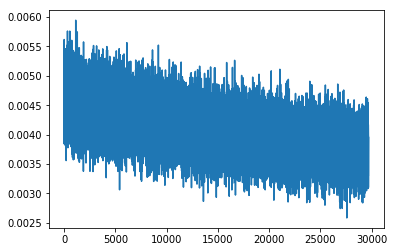

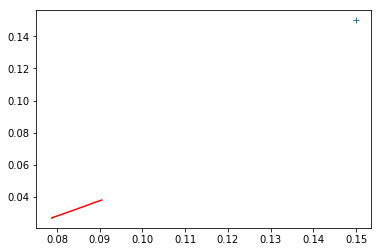

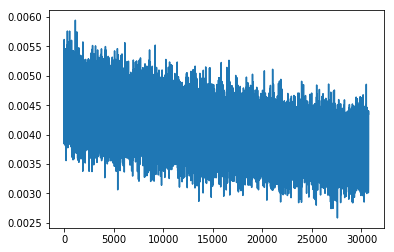

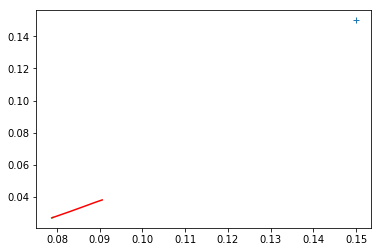

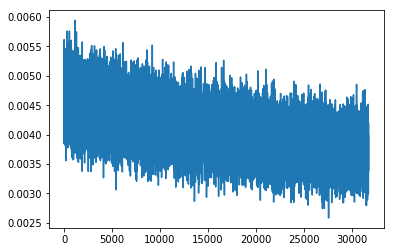

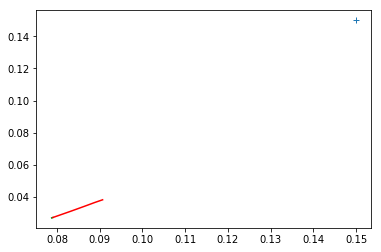

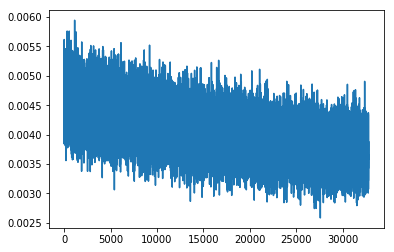

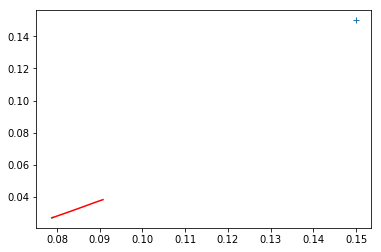

In [96]:
X = np.zeros((batch_size, 4))
Q_target = np.zeros((batch_size, 1))
U = np.zeros((batch_size, 2))
#x_mus = []
#y_mus = []
losses = []
for outer in range(32):
    for n in range(1024):
        for i in range(batch_size):
            x = random_in_range(-0.20, 0.20)
            y = random_in_range(-0.20, 0.20)
            U[i, :] = [x, y]
            Q_target[i, 0] = convex_shape(x, y)
        losses.append(nn.train_q(X, u, Q_target))
        x_mu, y_mu = nn.mu(np.array([[0.0, 0.0, 0.0, 0.0]]))
        x_mus.append(x_mu)
        y_mus.append(y_mu)
    
    plt.plot(losses)
    plt.show()
    plt.plot(x_mus[:512], y_mus[:512], 'g')
    plt.plot(x_mus[512:], y_mus[512:], 'r')
    plt.plot(0.15, 0.15, '+')
    plt.show()

In [ ]:
def plot_v(nn, batch_size=256, x=0.0, y=0.2, filename=None):
    xs = np.linspace(-0.20, 0.20, 16)
    ys = np.linspace(0.10, 0.30, 16)
    x = np.array([[a, b, x, y] for a in xs for b in ys], dtype=np.float32)
    v = nn.value_function(x)

    xs, ys = np.meshgrid(xs, ys)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    zs = np.zeros((16, 16))
    for i in range(16):
        for j in range(16):
            zs[i, j] = v[i * 16 + j]
    ax.plot_surface(xs, ys, zs, cmap='viridis', shade=True)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    ax.set_zlabel('$V(\mathbf{s})$')
    plt.axis('equal')
    if filename:
        plt.savefig(filename)
    plt.show()
    
plot_v(nn)

In [ ]:
def plot_pi(nn, batch_size=256, goal_x=0.0, goal_y=0.2, filename=None):
    xs = np.linspace(-0.2, 0.2, 16)
    ys = np.linspace(0.10, 0.30, 16)
    for x in xs:
        for y in ys:
            state = create_state_vector(x, y, goal_x, goal_y)
            mu = nn.mu(state)
            dx, dy = mu
            #d = np.linalg.norm([dx, dy])
            dx /= 6
            dy /= 6
            plt.arrow(x, y, dx, dy, color='k')
    plt.plot(goal_x, goal_y, 'ro')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('$\mathbf{\mu(s)}$')
    plt.xlim((-0.2, 0.2))
    plt.ylim((0.10, 0.30))
    if filename:
        plt.savefig(filename)
    plt.show()
    
plot_pi(nn)

In [ ]:
replay_buffer = PriorityBuffer(2 ** 19)
best_params = None
best_score = -np.inf
scores = []
epsilon = 0.1

In [ ]:
batch_queue = Queue(maxsize=64)
batch_queue_stop = False
exists_batch_workers = False

def batch_queue_filler():
    while not batch_queue_stop:
        X = np.zeros((batch_size, 4), dtype=np.float32)
        Xp = np.zeros((batch_size, 4), dtype=np.float32)
        U = np.zeros((batch_size, 2), dtype=np.float32)
        R = np.zeros((batch_size, 1), dtype=np.float32)
        exp_nodes = []
        for j in range(batch_size):
            exp_nodes.append(replay_buffer.sample())
            state, state_prim, c_x, c_y, reward = exp_nodes[-1].data
            X[j, :] = state
            Xp[j, :] = state_prim
            U[j, :] = [c_x, c_y]
            R[j, :] = reward
        batch_queue.put((exp_nodes, X, Xp, U, R))
    print('batch worker stopping')

In [ ]:
def reset_env(e):
    e.reset()
    e.goal_x = 0.0
    e.goal_y = 0.20

n_iterations = 1048

n = 1
for n in range(n, n_iterations + 1):
    # gather a batch from current policy
    reset_env(e)
    for i in range(batch_size):
        if np.sqrt((e.goal_x - e.eef_x) ** 2 + (e.goal_y - e.eef_y) ** 2) < 0.01:
            reset_env(e)
        noise_x = np.random.randn() / 20.0
        noise_y = np.random.randn() / 20.0
        state = create_state_vector(e.eef_x, e.eef_y, e.goal_x, e.goal_y)
        control = nn.mu(state)
        c_x, c_y = control
        c_x += noise_x
        c_y += noise_y
        reward = e.move(c_x, c_y)
        state_prim = create_state_vector(e.eef_x, e.eef_y, e.goal_x, e.goal_y)
        exp_node = replay_buffer.add((state, state_prim, c_x, c_y, reward))
        exp_node.set_value(100.0)
        if reward == -1:
            reset_env(e)
            
    if not exists_batch_workers:
        [threading.Thread(target=batch_queue_filler).start() for _ in range(8)]
        print('starting batch workers')
        exists_batch_workers = True
            
    # train
    alpha = 2.0
    for i in range(512):
        exp_nodes, X, Xp, U, R = batch_queue.get()
        err, td_errors = nn.train_squared(X, Xp, U, R)
        for exp_node, td_error in zip(exp_nodes, td_errors):
            exp_node.set_value((abs(td_error) + epsilon) ** alpha)
    score = test_score(e, nn)
    if score > best_score:
        best_params = [p.get_value() for p in nn.params]
    scores.append(score)
    print(replay_buffer)
    print('approximate queue size:', batch_queue.qsize())
    plt.plot(scores)
    plt.show()
    plot_pi(nn, goal_x=e.goal_x, goal_y=e.goal_y, filename='pi_plots/pi{:05d}.pdf'.format(n))
    plot_v(nn, x=e.goal_x, y=e.goal_y, filename='v_plots/v{:05d}.pdf'.format(n))

In [ ]:
eef_x = -0.1
eef_y = 0.25
goal_x = 0.0
goal_y = 0.2
dx, dy = nn.mu(create_state_vector(eef_x, eef_y, goal_x, goal_y))
dx, dy